In [1]:
# Import statements
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

In [2]:
# Main SEIR function
def gillespie_seir(N, beta_func, delta, gamma, mu, initial_infected, initial_exposed, max_time, *beta_args):
    # Initial conditions
    S = N - initial_infected - initial_exposed
    E = initial_exposed
    I = initial_infected
    R = 0
    
    # Arrays to store results
    times = [0]
    susceptible = [S]
    exposed = [E]
    infected = [I]
    recovered = [R]
    
    t = 0
    beta = beta_func(t, beta_args)
    while t < max_time:
        # Calculate rates (transmission, symptom onset, recovery, birth and deaths)
        beta = beta_func(t, beta_args)
        lambda_SE = beta * S * I / N
        lambda_EI = delta * E
        lambda_IR = gamma * I
        lambda_birth = mu * N
        lambda_death_S = mu * S
        lambda_death_E = mu * E
        lambda_death_I = mu * I
        lambda_death_R = mu * R
        total_rate = (lambda_SE + lambda_EI + lambda_IR + lambda_birth +
                      lambda_death_S + lambda_death_E + lambda_death_I + lambda_death_R)
        
        if total_rate == 0:
            break
        
        # Calculate time step
        dt = np.random.exponential(1 / total_rate)
        t += dt
        
        # Determine which event occurs
        rand = np.random.rand() * total_rate
        
        # Work out which event had happened
        if rand < lambda_SE:
            S -= 1
            E += 1
        elif rand < lambda_SE + lambda_EI:
            E -= 1
            I += 1
        elif rand < lambda_SE + lambda_EI + lambda_IR:
            I -= 1
            R += 1
        elif rand < lambda_SE + lambda_EI + lambda_IR + lambda_birth:
            S += 1
        else:
            rand_death = rand - (lambda_SE + lambda_EI + lambda_IR + lambda_birth)
            if rand_death < lambda_death_S:
                S -= 1
            elif rand_death < lambda_death_S + lambda_death_E:
                E -= 1
            elif rand_death < lambda_death_S + lambda_death_E + lambda_death_I:
                I -= 1
            else:
                R -= 1
        
        # Append results
        times.append(t)
        susceptible.append(S)
        exposed.append(E)
        infected.append(I)
        recovered.append(R)
    
    return times, susceptible, exposed, infected, recovered

In [3]:
# Four beta(t) functions for the simulations: 
# Constant, increasing gradually, decreasing gradually, step-decrease
def beta_constant(t, beta0):
    return beta0[0]

def beta_increasing(t, *beta_args):
    beta0, p, tau = beta_args[0]
    return beta0*(1+p*(t-tau)) if t > tau else beta0

def beta_decreasing(t, *beta_args):
    beta0, p, tau = beta_args[0]
    return beta0*(1-p*(t-tau)) if t > tau else beta0

def beta_step(t, *beta_args):
    beta0, beta1, tau = beta_args[0]
    return beta0 if t<tau else beta1

In [8]:
# Constant Parameters
N = 1e5  # Total population
delta = 1/3 # Symptom onset rate (1/delta is the infectious)
gamma = 1/7  # Recovery rate (1/gamma is the infectious period)
mu = 0.01  # Birth and death rate
initial_infected = 100
initial_exposed = 0
max_time = 20
beta0 = 1
num_res = 50

In [24]:
# Run simulation
def constant_sim(alg):
    return alg(N, beta_constant, delta, gamma, mu, initial_infected, initial_exposed, max_time, beta0)

runs = [gillespie_seir for i in range(num_res)]

with Pool(12) as pool:
    res = pool.map(constant_sim, runs)

times = np.arange(0,20.1,0.1)
I_constant = np.zeros((num_res,len(times)))
for i in range(num_res):
    I_constant[i,:] = np.interp(times,res[i][0],res[i][3])

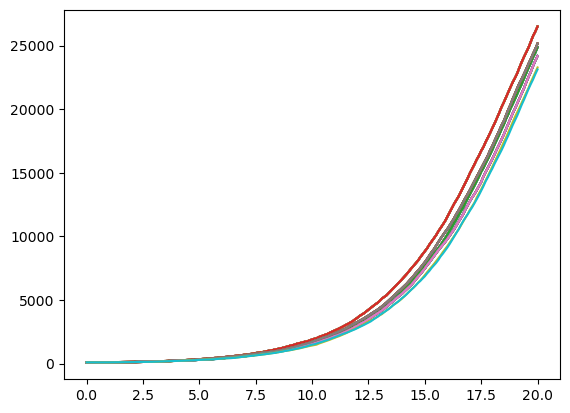

In [26]:
fig, ax = plt.subplots()
for i in range(num_res):
    plt.plot(times,I_constant[i])
plt.show()

In [11]:
# Run simulation
betalow = 0.1
p = 0.1
tau = 1
def increasing_sim(alg):
    return alg(N, beta_increasing, delta, gamma, mu, initial_infected, initial_exposed, max_time, betalow, p, tau)

with Pool(12) as pool:
    res_increasing = pool.map(increasing_sim, runs)

times = np.arange(0,20.1,0.1)
I_increasing = np.zeros((num_res,len(times)))
for i in range(num_res):
    I_increasing[i,:] = np.interp(times,res[i][0],res[i][3])

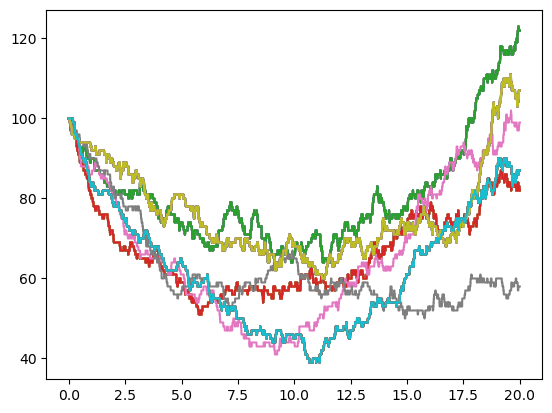

In [12]:
fig, ax = plt.subplots()
for i in range(num_res):
    plt.plot(times,I_increasing[i])
plt.show()

In [13]:
# Run simulation
p = 0.1
tau = 1
def decreasing_sim(alg):
    return alg(N, beta_decreasing, delta, gamma, mu, initial_infected, initial_exposed, max_time, beta0, p, tau)

with Pool(12) as pool:
    res_decreasing = pool.map(decreasing_sim, runs)

times = np.arange(0,20.1,0.1)
I_decreasing = np.zeros((num_res,len(times)))
for i in range(num_res):
    I_decreasing[i,:] = np.interp(times,res[i][0],res[i][3])

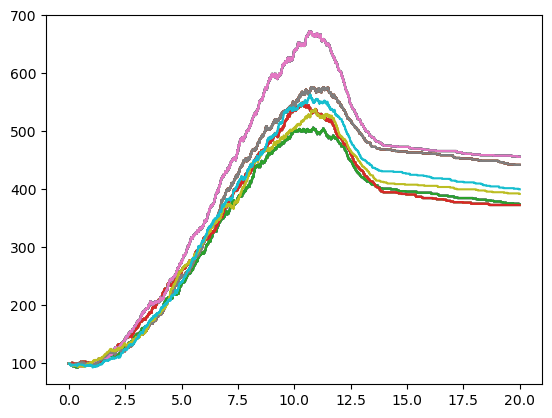

In [14]:
fig, ax = plt.subplots()
for i in range(num_res):
    plt.plot(times,I_decreasing[i])
plt.show()

In [15]:
# Run simulation
beta1 = 0.1*beta0
tau = 5
def step_sim(alg):
    return alg(N, beta_step, delta, gamma, mu, initial_infected, initial_exposed, max_time, beta0, beta1, tau)

with Pool(12) as pool:
    res_step = pool.map(step_sim, runs)

times = np.arange(0,20.1,0.1)
I_step = np.zeros((num_res,len(times)))
for i in range(num_res):
    I_step[i,:] = np.interp(times,res[i][0],res[i][3])

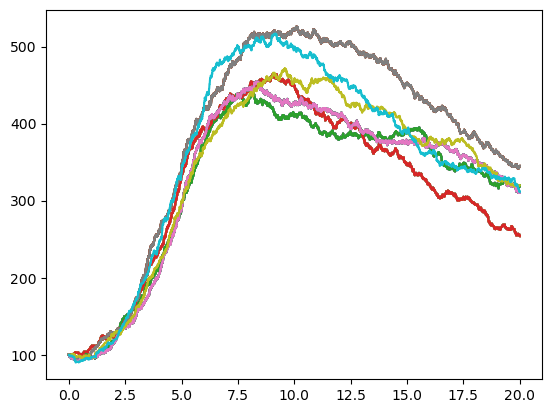

In [16]:
fig, ax = plt.subplots()
for i in range(num_res):
    plt.plot(times,I_step[i])
plt.show()